In [1]:
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable

import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.models import vgg19
import functools

from skimage.io import imread, imsave
from skimage import img_as_float, img_as_uint
from skimage.measure import compare_psnr
from skimage.transform import resize
from skimage.measure import compare_psnr
import cv2

from artificial_bluring import blur_img
from IPython import display

from copy import deepcopy
from models.instancenormrs import *

from torch.utils.data import Dataset

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm, tqdm_notebook
from tensorboardX import SummaryWriter

from utils import *
from network_models import *
from traintest import *
from unet import *

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

#### ResGEN:

In [3]:
coco_path = 'coco/unlabeled2017/'
coco_files = np.random.choice(os.listdir(coco_path), size=1500, replace=False)
coco_files_train = coco_files[:1000]
coco_files_test = coco_files[1000:]

coco_files_train = list(map(lambda x: coco_path+x, coco_files_train))
coco_files_test = list(map(lambda x: coco_path+x, coco_files_test))

In [4]:
#exp21
norm_layer = get_norm_layer()

D = NLayerDiscriminatorRF(input_nc=3, n_layers=4, ndf=128, norm_layer=norm_layer, gpu_ids=[0,1,2])

device = torch.device("cuda:0")
D.cuda();

In [21]:
gen_arg = {'input_nc':3, 'input_enc':9, 'output_nc':3, 'ngf':128, 'norm_layer':get_norm_layer(),
           'use_dropout':True, 'n_blocks':9, 'gpu_ids':[0,1,2], 'use_parallel':False,
           'learn_residual':True, 'padding_type':'zero', 'partial_downsample':False}

G = ResnetGenerator(**gen_arg)
G.cuda();

In [8]:
D.load_state_dict(torch.load('ResDisc_exp21.pth'))
G.load_state_dict(torch.load('ResGen_exp21.pth'))

In [22]:
print('G:', sum(p.numel() for p in G.parameters() if p.requires_grad))
print('D:', sum(p.numel() for p in D.parameters() if p.requires_grad))

G: 31657219
D: 44590977


In [8]:
data = GOPRO_extended(include_sharp=500, include_coco=None,#{'train':coco_files_train, 'test':coco_files_test}, 
                      returnLP=3,
                      desired_shape=([360,480],[640]),
                      transform=False)#,
                      #crop=(256,256))

/data/install/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


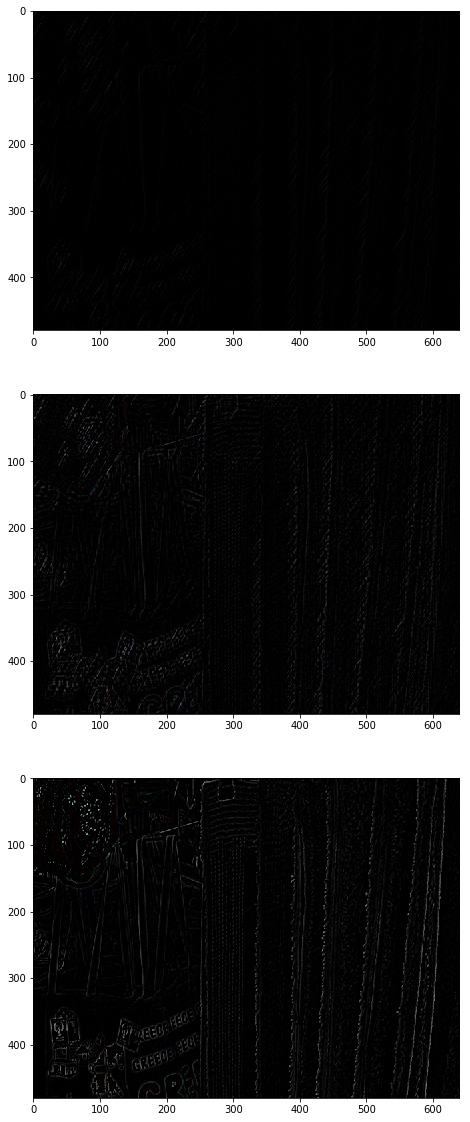

In [9]:
datas = torch.utils.data.DataLoader(data, batch_size=1, shuffle=True)
(blurred_LP,blurred), (sharp_LP, sharp) = next(iter(datas))

target = sharp_LP[-1]
main_blurred, aux_blurred = get_network_tensors(blurred_LP, base_lvl=-1)

X_fake = G(Variable(main_blurred).cuda().detach(),Variable(aux_blurred).cuda().detach())
X_real = Variable(target).cuda()

fig, ax = plt.subplots(3,1, figsize=(15,20))

ax[0].imshow(np.transpose(Variable(main_blurred).cuda()[0,...].cpu().data.numpy(),[1,2,0]))
#ax[0].set_title(str(D(Variable(main_blurred).cuda()).mean().item()));

ax[1].imshow(np.transpose(X_fake[0,...].cpu().data.numpy(),[1,2,0])*2)
#ax[1].set_title(str(D(X_fake).mean().item()));

ax[2].imshow(np.transpose(X_real[0,...].cpu().data.numpy(),[1,2,0])*2);
#ax[2].set_title(D(X_real).mean().item());

In [11]:
reals, fakes = [],[]
for _ in tqdm(range(500)):
    datas = torch.utils.data.DataLoader(data, batch_size=1, shuffle=True)
    (blurred_LP,blurred), (sharp_LP, sharp) = next(iter(datas))

    target = sharp_LP[-1]
    main_blurred, aux_blurred = get_network_tensors(blurred_LP, base_lvl=-1)
    
    X_fake = G(Variable(main_blurred).cuda().detach(),Variable(aux_blurred).cuda().detach())
    X_real = Variable(target).cuda()
    
    reals.append(D(X_real).mean().item())
    fakes.append(D(X_fake).mean().item())

print(np.mean(reals))
print(np.mean(fakes))
print(np.mean(reals)-np.mean(fakes))

  0%|          | 0/500 [00:00<?, ?it/s]/data/install/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 500/500 [04:49<00:00,  1.73it/s]

0.4381784257143736
0.4138594196010381
0.024319006113335484


In [12]:
test_data = GOPRO_extended(include_sharp=0,
                           train=True,
                           include_coco={'train':coco_files_train, 'test':coco_files_test}, 
                           returnLP=3,
                           transform=False,
                           desired_shape=([360,480],[640]))

#### UnetGen:

In [ ]:
del G, D, norm_layer, main_blurred, aux_blurred, target, X_fake, X_real, recon,gt,orig, psnr

In [16]:
norm_layer = get_norm_layer()

D = NLayerDiscriminatorRF(input_nc=3, n_layers=4, ndf=128, norm_layer=norm_layer, gpu_ids=[0,1,2])

device = torch.device("cuda:0")
D.cuda();

In [17]:
G = UNetGenerator(input_nc=6, output_nc=3, ngf=64, norm_layer=norm_layer)
G.cuda();

In [18]:
D.load_state_dict(torch.load('unet_disc_exp1.pth'))
G.load_state_dict(torch.load('unet_gen_exp1.pth'))

/data/install/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


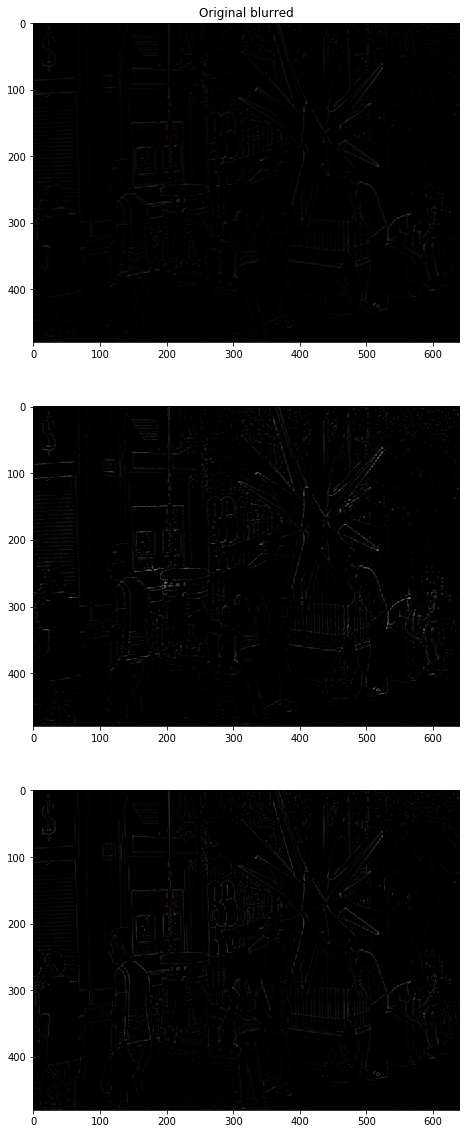

In [18]:
datas = torch.utils.data.DataLoader(data, batch_size=1, shuffle=True)
(blurred_LP,blurred), (sharp_LP, sharp) = next(iter(datas))

target = sharp_LP[-1]

main_blurred = blurred_LP[-1]
blurred_img = blurred.transpose(dim0=2, dim1=3).transpose(dim0=1, dim1=2).float()
main_blurred = torch.cat([main_blurred, blurred_img],1)

X_fake = G(Variable(main_blurred).cuda().detach())
X_real = Variable(target).cuda().detach()

fig, ax = plt.subplots(3,1, figsize=(15,20))

ax[0].imshow(np.transpose(main_blurred[0,:3].data.cpu().numpy(), [1,2,0]))
ax[0].set_title('Original blurred');

ax[1].imshow(np.transpose(X_fake[0,...].cpu().data.numpy(),[1,2,0]))
#ax[1].set_title(str(D(X_fake).mean().item()));

ax[2].imshow(np.transpose(X_real[0,...].cpu().data.numpy(),[1,2,0]));
#ax[2].set_title(D(X_real).mean().item());

In [20]:
reals, fakes = [],[]
for _ in tqdm(range(500)):
    datas = torch.utils.data.DataLoader(data, batch_size=1, shuffle=True)
    (blurred_LP,blurred), (sharp_LP, sharp) = next(iter(datas))

    target = sharp_LP[-1]
    main_blurred = blurred_LP[-1]
    blurred_img = blurred.transpose(dim0=2, dim1=3).transpose(dim0=1, dim1=2).float()
    main_blurred = torch.cat([main_blurred, blurred_img],1)
    
    X_fake = G(Variable(main_blurred).cuda().detach())
    X_real = Variable(target).cuda()
    
    reals.append(D(X_real).mean().item())
    fakes.append(D(X_fake).mean().item())

print(np.mean(reals))
print(np.mean(fakes))
print(np.mean(reals)-np.mean(fakes))

  0%|          | 0/500 [00:00<?, ?it/s]/data/install/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 500/500 [03:49<00:00,  2.18it/s]

-1.1145759278461338
-1.3665775219351053
0.2520015940889715
